In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle,glob
from MLutils import  diversity_heatmap, merge_pickles_pred_dicts, diversity_matrix
from sklearn.metrics import  accuracy_score, cohen_kappa_score

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [4]:
import pandas as pd

In [5]:
pickle_list = glob.glob('ml_predictions/*.pkl')

In [6]:
pickle_list

['ml_predictions/CNN_test.pkl',
 'ml_predictions/results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/fasttext.pkl',
 'ml_predictions/pipeline_testresults_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64.pkl',
 'ml_predictions/results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100,.pkl']

In [7]:
# pickle_list = ['ml_predictions/CNN_test.pkl',
#               'ml_predictions/pipeline_testresults_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl'
#               ]

In [8]:
results_dict = merge_pickles_pred_dicts(pickle_list, f1_threshold=0.49)

Merged 8 different model variations


In [35]:
ml_models = results_dict.keys()
ml_models.sort()

In [36]:
ml_models

['CNN_test_CNN',
 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression']

In [11]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [19]:
# del results_dict['fasttext_fasttext']
del results_dict['pipeline_testresults_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression']

In [14]:
for key in results_dict.keys():
    print key
    print results_dict[key].keys()
    
    print ''

RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM
['label_val_prob+', 'label_test_prob+', 'classification_report', 'label_unlab_prob+', 'f1+']

results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression
['label_val_prob+', 'label_test_prob+', 'classification_report', 'label_unlab_prob+', 'f1+']

results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression
['label_val_prob+', 'label_test_prob+', 'classification_report', 'label_unlab_prob+', 'f1+']

results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
['label_val_prob+', 'label_test_prob+', 'classification_report', 'label_unlab_prob+', 'f1+']

pipeline_testresults_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression
['label_val_prob+', 'label_test_prob+', 'classification_report', 'label_unlab_prob+', 'f1+']

results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticReg

In [20]:
diversity_matrix(results_dict, metric=cohen_kappa_score)

,CNN_test_CNN,"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM","results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression","results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression","results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear","results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression"
CNN_test_CNN,1,0.397403,0.617688,0.62543,0.579467,0.569876
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",0.397403,1,0.408124,0.402711,0.404258,0.374633
"results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression",0.617688,0.408124,1,0.710513,0.609656,0.550154
"results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression",0.62543,0.402711,0.710513,1,0.535357,0.619385
"results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",0.579467,0.404258,0.609656,0.535357,1,0.696873
"results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression",0.569876,0.374633,0.550154,0.619385,0.696873,1


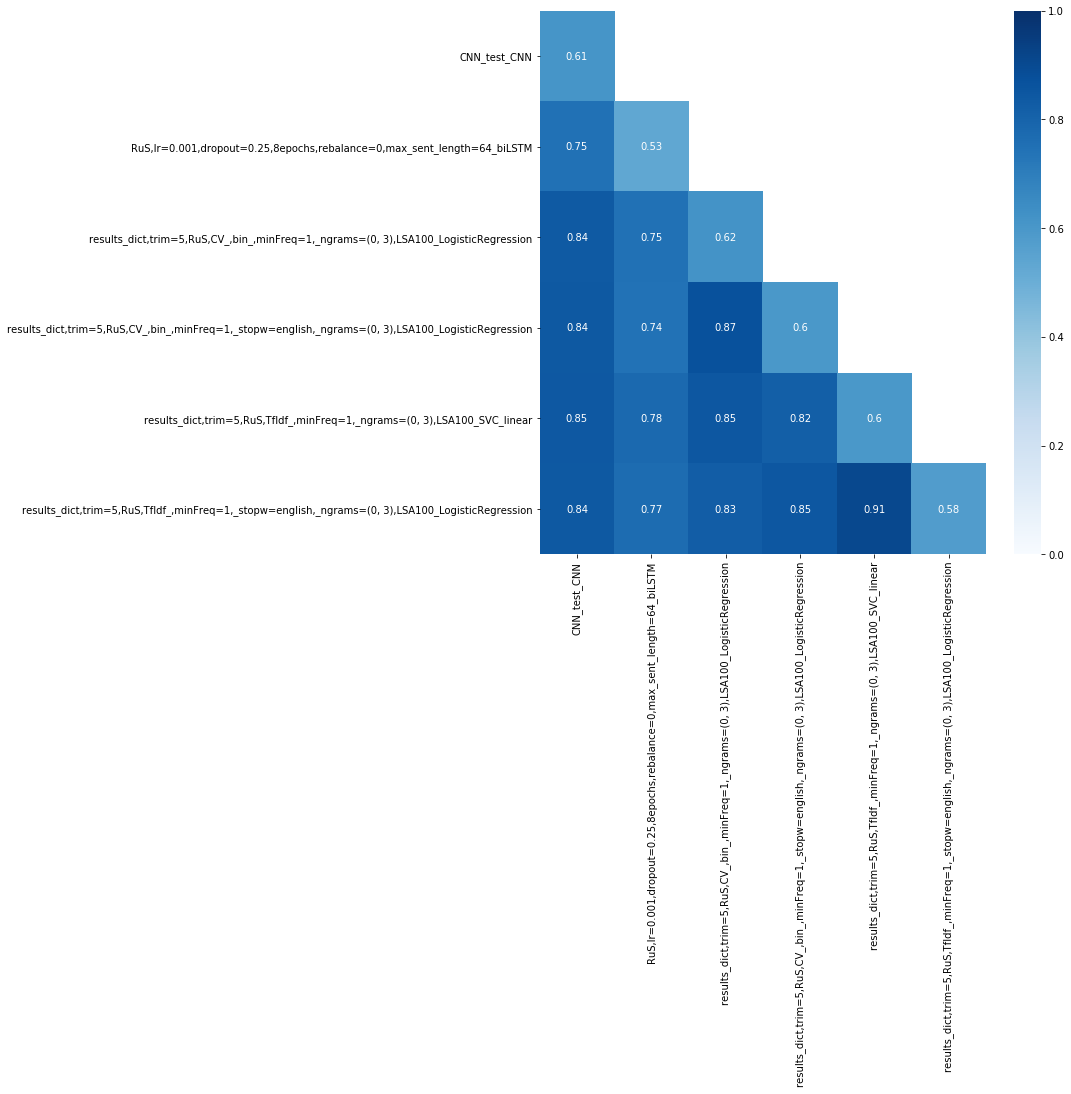

In [21]:
diversity_heatmap(results_dict, metric=accuracy_score,diagonal_key='f1+')

In [22]:
# explore dict

In [23]:
results_dict.keys()

['RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression',
 'CNN_test_CNN']

In [24]:
results_dict['results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression'].keys()

['label_val_prob+',
 'label_test_prob+',
 'classification_report',
 'label_unlab_prob+',
 'f1+']

# Clustering

In [26]:
# Load data

In [27]:
X = diversity_matrix(results_dict)

In [28]:
# Clustering directly with prediction matrix

# X = pd.DataFrame()
# for key in ml_models:
#     X[key] = pd.Series(results_dict[key]['label_val_binary'])

In [29]:
import seaborn as sns

In [41]:
n_clusters = 3

In [42]:
model = AgglomerativeClustering(n_clusters=n_clusters,
#                                 affinity=cohen_kappa_score,
#                                 linkage = 'average'
                               )
Z = model.fit_predict(X.T)

In [43]:
picked_models = []
for i in range(n_clusters): #for each cluster
    mean_ck = {}
    print '\nCluster',i
    min_mean_ck=10
    
    for j,m in enumerate(ml_models):
        if Z[j]==i:
            print ml_models[j]
            if min_mean_ck > X.mean()[ml_models[j]]: #determine minimum mean cohens kappa value out of cluster
                min_mean_ck = X.mean()[ml_models[j]]
                more_diverse_model = ml_models[j]
    
    # TODO: compute mean for those not in its own cluster
    print '\n\nPicked model "%s" out of cluster %i, with mean C.K.= %.2f'%(more_diverse_model,i,min_mean_ck )
    picked_models.append(more_diverse_model)
    


Cluster 0
CNN_test_CNN
results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression
results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression


Picked model "CNN_test_CNN" out of cluster 0, with mean C.K.= 0.63

Cluster 1
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM


Picked model "RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM" out of cluster 1, with mean C.K.= 0.50

Cluster 2
results_dict,trim=5,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression


Picked model "results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression" out of cluster 2, with mean C.K.= 0.64


In [44]:
def reduce_results_dict(results_dict, your_keys):
    """Reduces results_dict to selected models (your_keys)"""
    
    return {your_key: results_dict[your_key] for your_key in your_keys }

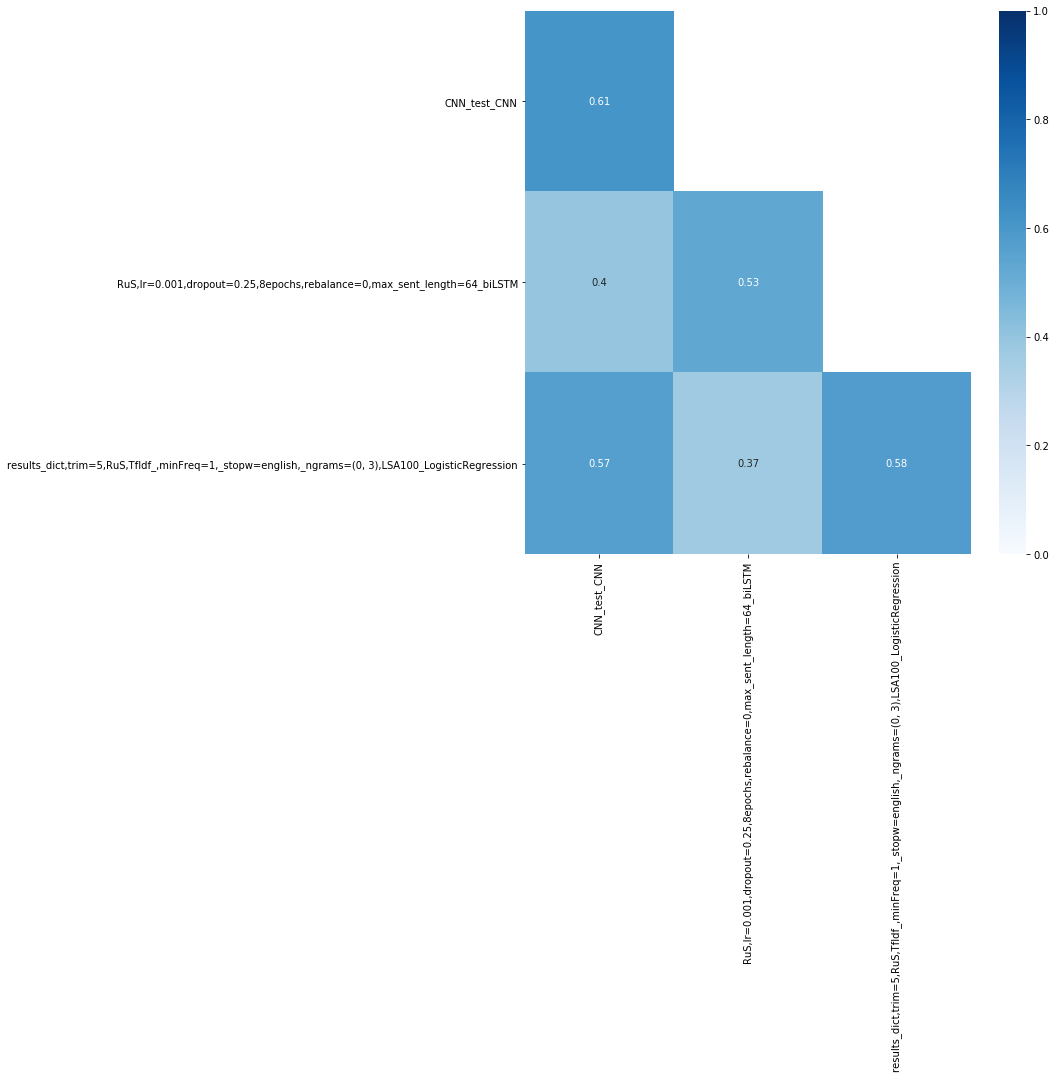

In [51]:
diversity_heatmap(reduce_results_dict(results_dict,picked_models), metric=cohen_kappa_score, diagonal_key='f1+')

In [46]:
selected_class_dict = reduce_results_dict(results_dict,picked_models) 

In [47]:
selected_class_dict.keys()

['results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression',
 'CNN_test_CNN',
 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM']

In [50]:
with open('ml_predictions/BOW_LSTM_CNN.pickle' ,'wb') as f:
    pickle.dump(selected_class_dict,f)

In [42]:
# for i,m in enumerate(ml_models):
#     print Z[i], '\t', m
#     # for each cluster, pick model with lowest 

## Dendrogram

In [73]:
from scipy.cluster import hierarchy

In [74]:
dn = hierarchy.dendrogram(Z)

TypeError: Linkage matrix 'Z' must contain doubles.

In [70]:
model.n_clusters

5

In [68]:
X

,"results_dict,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english_LogisticRegression","results_dict,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,ShortDepPath,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,RuS,TfIdf_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression","results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=0,RuS,TfIdf_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=3,_stopw=english_LogisticRegression","results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(2, 2)_LogisticRegression","RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64_biLSTM",...,"results_dict,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,trim=0,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,lemmas,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=5,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_linear","results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,ShortDepPath,RuS,TfIdf_,minFreq=3,_stopw=english_LogisticRegression","results_dict,trim=0,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_RandomForestClassifier"
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,-1,1,1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,-1,1,1,-1,-1
4,-1,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,-1,-1,-1,-1,-1,-1,1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,1,-1,1,-1,1,1,1,1,1,-1,...,-1,1,1,1,1,1,1,1,1,1


In [65]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
model.labels_

array([2, 2, 4, 2, 0, 1, 3, 3, 0, 0, 2, 1, 4, 3, 1, 0, 1, 4, 1, 3, 0, 2,
       3, 2, 3, 2, 1, 1, 3, 2, 1, 4, 3])

NameError: name 'metric' is not defined

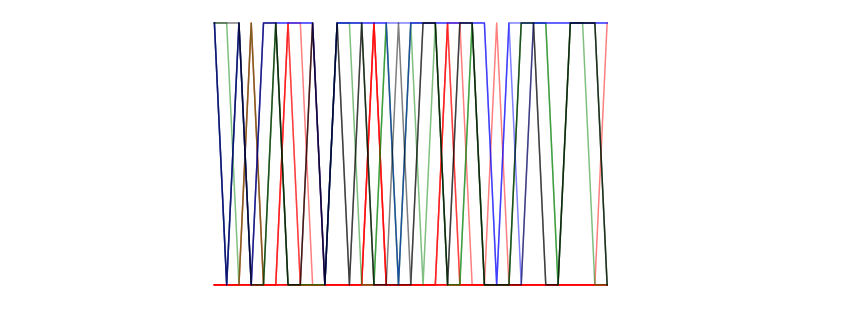

In [58]:
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
    plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
plt.axis('tight')
plt.axis('off')
plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=n_clusters,
                                affinity=cohen_kappa_score)
model.fit(X)
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
    plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
plt.axis('tight')
plt.axis('off')
plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
